Nesse projeto iremos modelar a sensibilidade da taxa de desemprego ao hiato do produto segundo a lei de Okun

# Carregamento de pacotes e bibliotecas

In [1]:
#Carregamento de Bibliotecas
import pandas as pd
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from functools import reduce

# Coleta e tratamento de Dados

In [7]:
#Importação da base de dados pnad_ampliada
pnad = pd.read_excel('/content/pnad_ampliada.xlsx', parse_dates=['Date'])


In [8]:
pnad

,Date,pnad,pnad_sa
0,2002-03-01,13.769594,13.215922
1,2002-04-01,13.415742,12.773219
2,2002-05-01,12.871943,12.481489
3,2002-06-01,12.609105,12.451337
4,2002-07-01,12.858390,12.826420
...,...,...,...
278,2025-05-01,6.200000,6.083071
279,2025-06-01,5.800000,5.878561
280,2025-07-01,5.600000,5.692496
281,2025-08-01,5.600000,5.747897


In [9]:
#Colocar a série em ordem trimestral
pnad_tri = (
    pnad.set_index('Date')
    .resample('Q')
    .last()
    .reset_index()
    .assign(Date=lambda x: pd.PeriodIndex(x.Date, freq='Q'))
)

/tmp/ipython-input-670167283.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


In [10]:
pnad_tri

,Date,pnad,pnad_sa
0,2002Q1,13.769594,13.215922
1,2002Q2,12.609105,12.451337
2,2002Q3,12.534196,12.481820
3,2002Q4,11.686315,12.878924
4,2003Q1,13.080500,12.553887
...,...,...,...
90,2024Q3,6.400000,6.578337
91,2024Q4,6.200000,6.482037
92,2025Q1,7.000000,6.461199
93,2025Q2,5.800000,5.878561


Hiato do produto calculado pelo BCB

In [23]:
hiato = (
    pd.read_excel(
        'https://www.bcb.gov.br/content/ri/relatorioinflacao/202509/rpm202509anp.xlsx',
        sheet_name='Graf 2.2.8',
        skiprows=8
    )
    .assign(
        Date=lambda x: pd.PeriodIndex(x['Trimestre'], freq='Q'),
        hiato=lambda x: x['Cenário de referência'].astype(float)
    )
    .loc[:, ['Date', 'hiato']]
)


In [21]:
hiato

,Date,hiato
0,NaT,NaN
1,2003Q4,-0.99
2,2004Q1,-0.54
3,2004Q2,-0.11
4,2004Q3,0.27
...,...,...
84,2024Q3,1.14
85,2024Q4,1.18
86,2025Q1,1.02
87,2025Q2,0.67


In [24]:
hiato = hiato.drop(0)
print(hiato)

      Date  hiato
1   2003Q4  -0.99
2   2004Q1  -0.54
3   2004Q2  -0.11
4   2004Q3   0.27
5   2004Q4   0.49
..     ...    ...
84  2024Q3   1.14
85  2024Q4   1.18
86  2025Q1   1.02
87  2025Q2   0.67
88  2025Q3   0.49

[88 rows x 2 columns]


Juntando os dados

In [25]:
#Lista com os data frames
df = [pnad_tri, hiato]
# reduz os data frames pela chave date_quarter com left join
base = reduce(lambda left, right: pd.merge(left, right, on='Date', how= 'left'), df).dropna()
#Altera o tipo da coluna data
base['Date'] = base.Date.dt.to_timestamp()

In [26]:
base

,Date,pnad,pnad_sa,hiato
7,2003-10-01,12.005856,13.260009,-0.99
8,2004-01-01,13.670039,13.125696,-0.54
9,2004-04-01,12.743190,12.587194,-0.11
10,2004-07-01,12.039800,12.026563,0.27
11,2004-10-01,10.920768,12.097860,0.49
...,...,...,...,...
90,2024-07-01,6.400000,6.578337,1.14
91,2024-10-01,6.200000,6.482037,1.18
92,2025-01-01,7.000000,6.461199,1.02
93,2025-04-01,5.800000,5.878561,0.67


# Lei de Okun: output gap

Aqui a NAIRU será estimada usando a técnica do filtro HP

In [27]:
# Calcula filtro HP
filtro_hp = sm.tsa.filters.hpfilter(x= base['pnad_sa'], lamb= 1600)

# Tendência acumulada
base['nairu'] = filtro_hp[1] #posição da tendencia, 0 é o ciclo

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format


In [28]:
base

,Date,pnad,pnad_sa,hiato,nairu
7,2003-10-01,12.005856,13.260009,-0.99,12.795171
8,2004-01-01,13.670039,13.125696,-0.54,12.609968
9,2004-04-01,12.743190,12.587194,-0.11,12.425057
10,2004-07-01,12.039800,12.026563,0.27,12.241049
11,2004-10-01,10.920768,12.097860,0.49,12.058658
...,...,...,...,...,...
90,2024-07-01,6.400000,6.578337,1.14,7.029264
91,2024-10-01,6.200000,6.482037,1.18,6.641638
92,2025-01-01,7.000000,6.461199,1.02,6.254704
93,2025-04-01,5.800000,5.878561,0.67,5.868143


from matplotlib import pyplot as plt
base['pnad'].plot(kind='hist', bins=20, title='pnad')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
base['pnad_sa'].plot(kind='hist', bins=20, title='pnad_sa')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
base['hiato'].plot(kind='hist', bins=20, title='hiato')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
base['nairu'].plot(kind='hist', bins=20, title='nairu')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
base.plot(kind='scatter', x='pnad', y='pnad_sa', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
base.plot(kind='scatter', x='pnad_sa', y='hiato', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
base.plot(kind='scatter', x='hiato', y='nairu', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['pnad']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = base.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('pnad')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['pnad_sa']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = base.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('pnad_sa')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['hiato']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = base.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('hiato')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['nairu']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = base.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('nairu')

from matplotlib import pyplot as plt
base['pnad'].plot(kind='line', figsize=(8, 4), title='pnad')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
base['pnad_sa'].plot(kind='line', figsize=(8, 4), title='pnad_sa')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
base['hiato'].plot(kind='line', figsize=(8, 4), title='hiato')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
base['nairu'].plot(kind='line', figsize=(8, 4), title='nairu')
plt.gca().spines[['top', 'right']].set_visible(False)

In [29]:
# Hiato do desemprego
base['desemprego_gap'] = base['pnad_sa'] - base['nairu']

In [30]:
base

,Date,pnad,pnad_sa,hiato,nairu,desemprego_gap
7,2003-10-01,12.005856,13.260009,-0.99,12.795171,0.464838
8,2004-01-01,13.670039,13.125696,-0.54,12.609968,0.515727
9,2004-04-01,12.743190,12.587194,-0.11,12.425057,0.162137
10,2004-07-01,12.039800,12.026563,0.27,12.241049,-0.214486
11,2004-10-01,10.920768,12.097860,0.49,12.058658,0.039202
...,...,...,...,...,...,...
90,2024-07-01,6.400000,6.578337,1.14,7.029264,-0.450927
91,2024-10-01,6.200000,6.482037,1.18,6.641638,-0.159602
92,2025-01-01,7.000000,6.461199,1.02,6.254704,0.206495
93,2025-04-01,5.800000,5.878561,0.67,5.868143,0.010418


Avaliando a relação entre hiato do produto e o hiato do desemprego

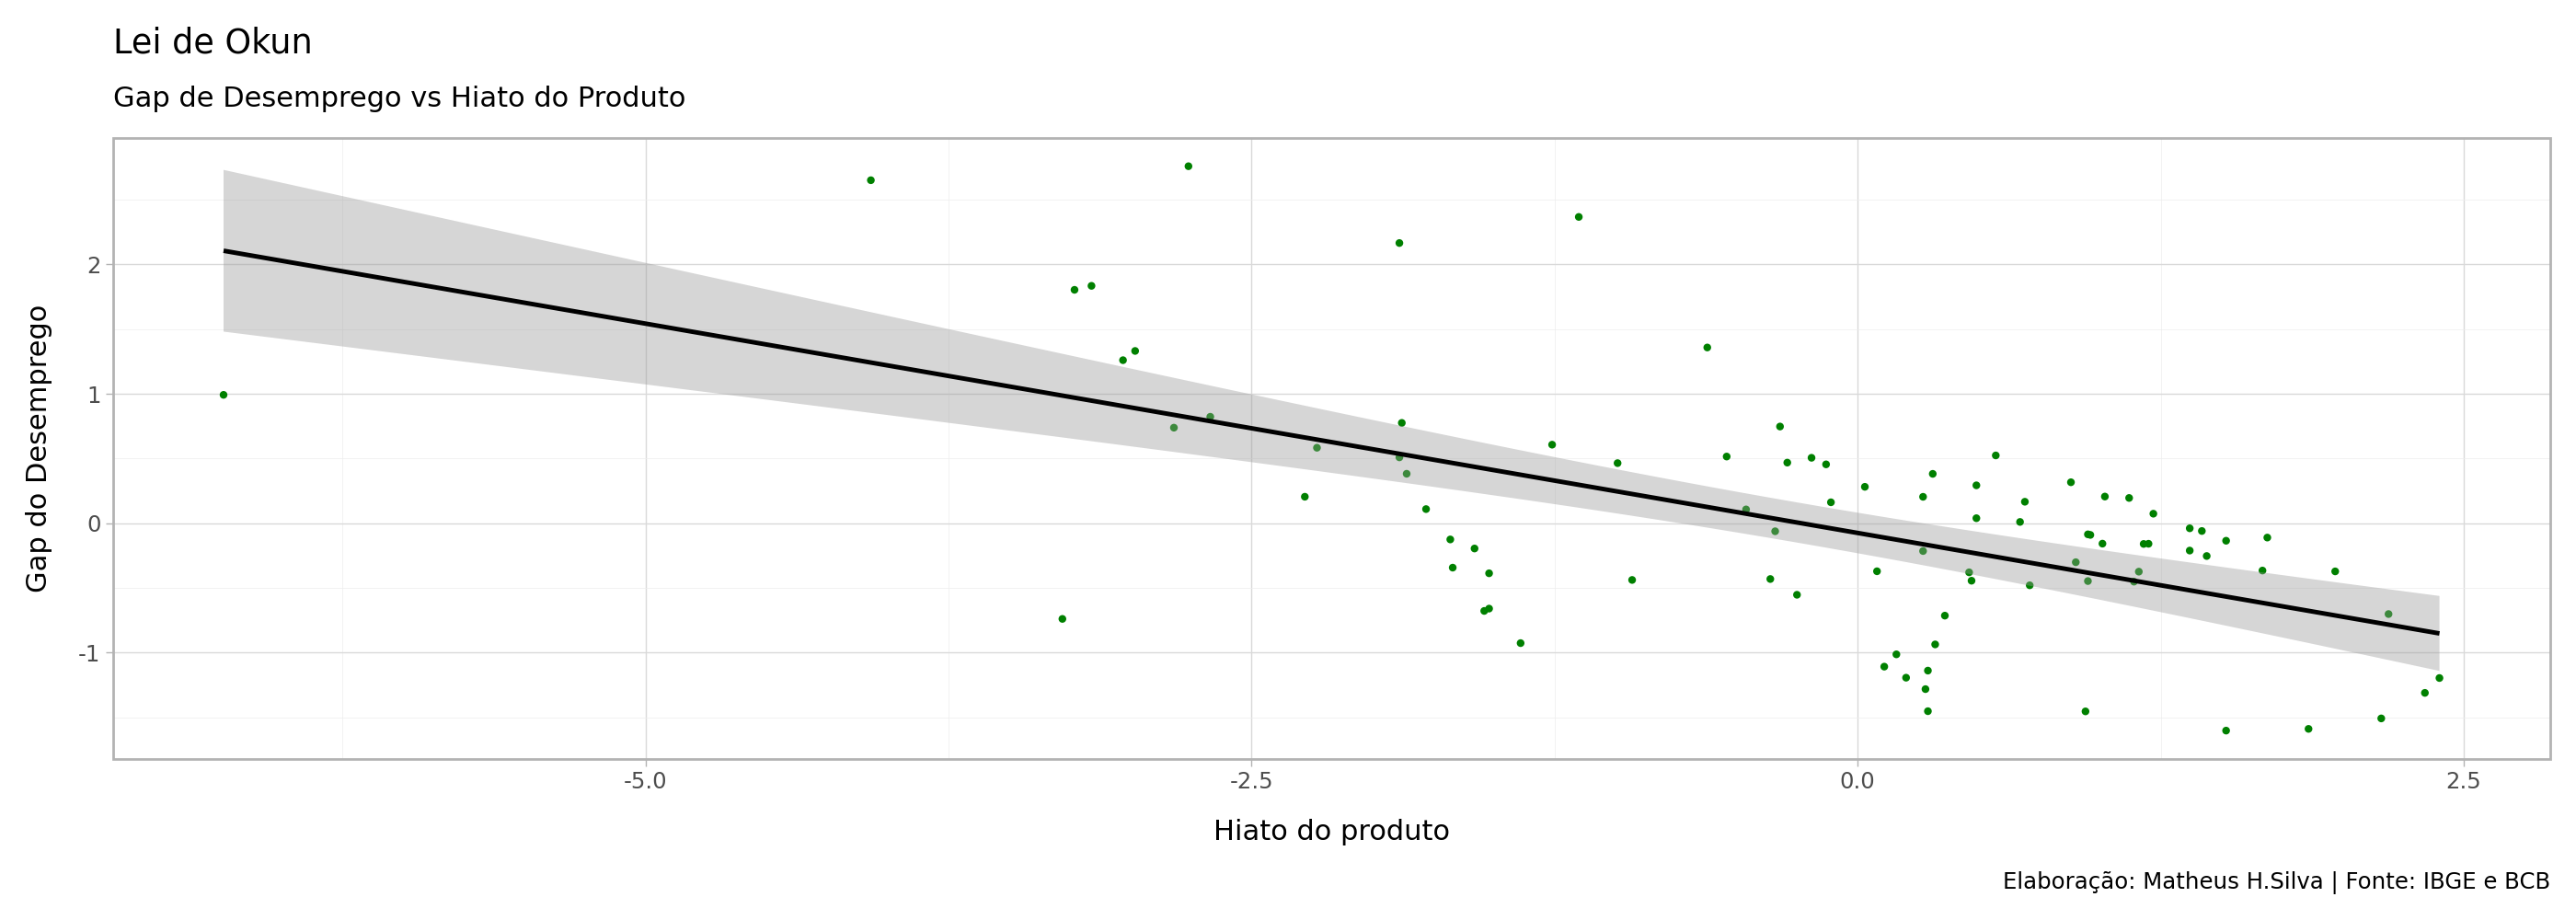

In [32]:
#gráfico
(
 ggplot(base, aes(x= 'hiato', y= 'desemprego_gap'))+
 geom_point(size = 0.7, color = 'green')+
 stat_smooth(method = 'lm')+
 labs(title= f'Lei de Okun',
      subtitle = 'Gap de Desemprego vs Hiato do Produto',
      color='',
      x='Hiato do produto',
      y='Gap do Desemprego',
      caption='Elaboração: Matheus H.Silva | Fonte: IBGE e BCB')+
 theme_light() + theme(figure_size= (14,5), legend_position='bottom')
 )

In [33]:
#Criando gráfico
base_long = base[['Date', 'hiato', 'desemprego_gap']].melt(id_vars = ['Date'])

/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


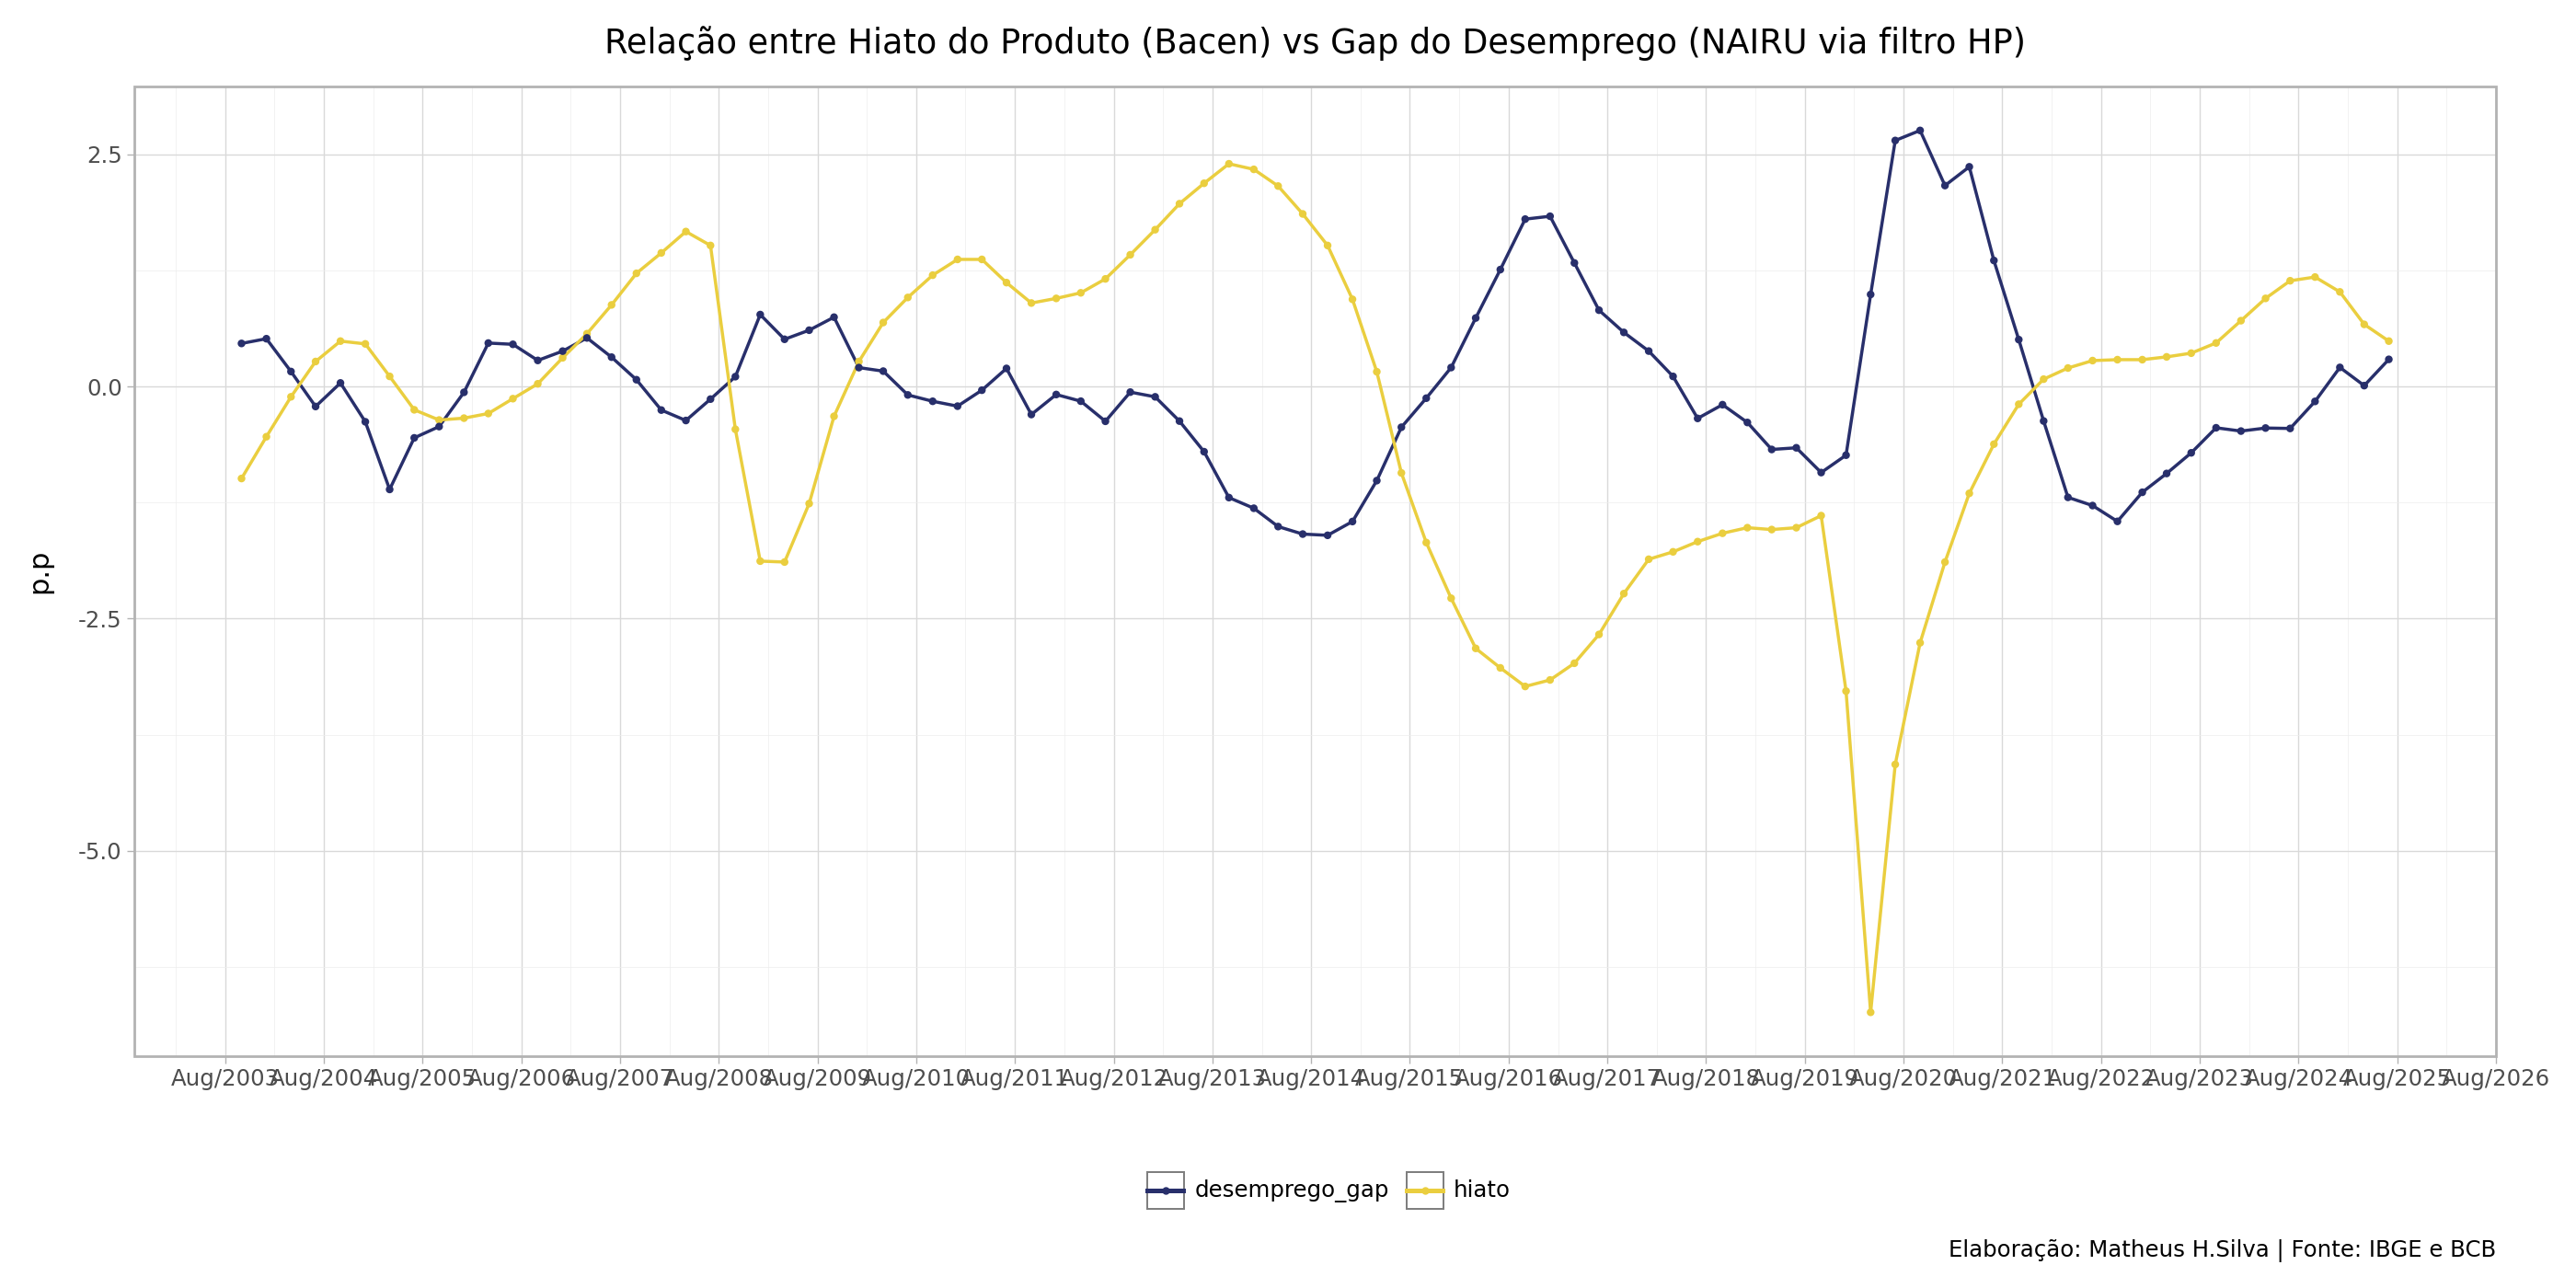

In [35]:
#Gráfico
colors = {'blue': '#282f6b',
          'yellow': '#eace3f',
          'red': '#b22200',
          'green': '#224f20',
          'purple': '#5f487c',
          'gray': '#666666',
          'orange': '#b35c1e'}
(ggplot(base_long, aes(x= 'Date', y= 'value', color= 'variable'))+
 geom_line(size = 0.7)+
 geom_point(size = 0.7)+
 scale_colour_manual(values=list(colors.values()))+
 scale_x_date(date_breaks='12 month', date_labels='%b/%Y')+
 labs(title= f'Relação entre Hiato do Produto (Bacen) vs Gap do Desemprego (NAIRU via filtro HP)',
      color='',
      x='',
      y='p.p',
      caption='Elaboração: Matheus H.Silva | Fonte: IBGE e BCB')+
 theme_light() + theme(figure_size= (14,7), legend_position='bottom')
 )

# Estimando modelo econométrico

In [36]:
#Modelo Estático
modelo_estatico = smf.ols(formula= 'desemprego_gap ~ hiato', data= base).fit()
print(modelo_estatico.summary())

                            OLS Regression Results                            
Dep. Variable:         desemprego_gap   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     47.83
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           7.76e-10
Time:                        22:37:36   Log-Likelihood:                -96.436
No. Observations:                  88   AIC:                             196.9
Df Residuals:                      86   BIC:                             201.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0747      0.079     -0.948      0.3

In [40]:
#Função para regressão móvel
def roll_estimate(data, window_size, min_obs):
    result = (RollingOLS.from_formula(formula= 'desemprego_gap ~ 1+hiato', data= data, window= window_size, min_nobs= min_obs)
              .fit()
              .params[['Intercept', 'hiato']])
    result = pd.DataFrame(result).rename({'Intercept': 'Constante'}, axis = 1)
    result['Date'] = data['Date']
    return result

In [41]:
# Cria estimativa
okun_roll = roll_estimate(base, window_size= 52, min_obs= 48).dropna()

In [42]:
okun_roll_long = okun_roll[['Date', 'Constante', 'hiato']].melt(id_vars = ['Date'])

/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


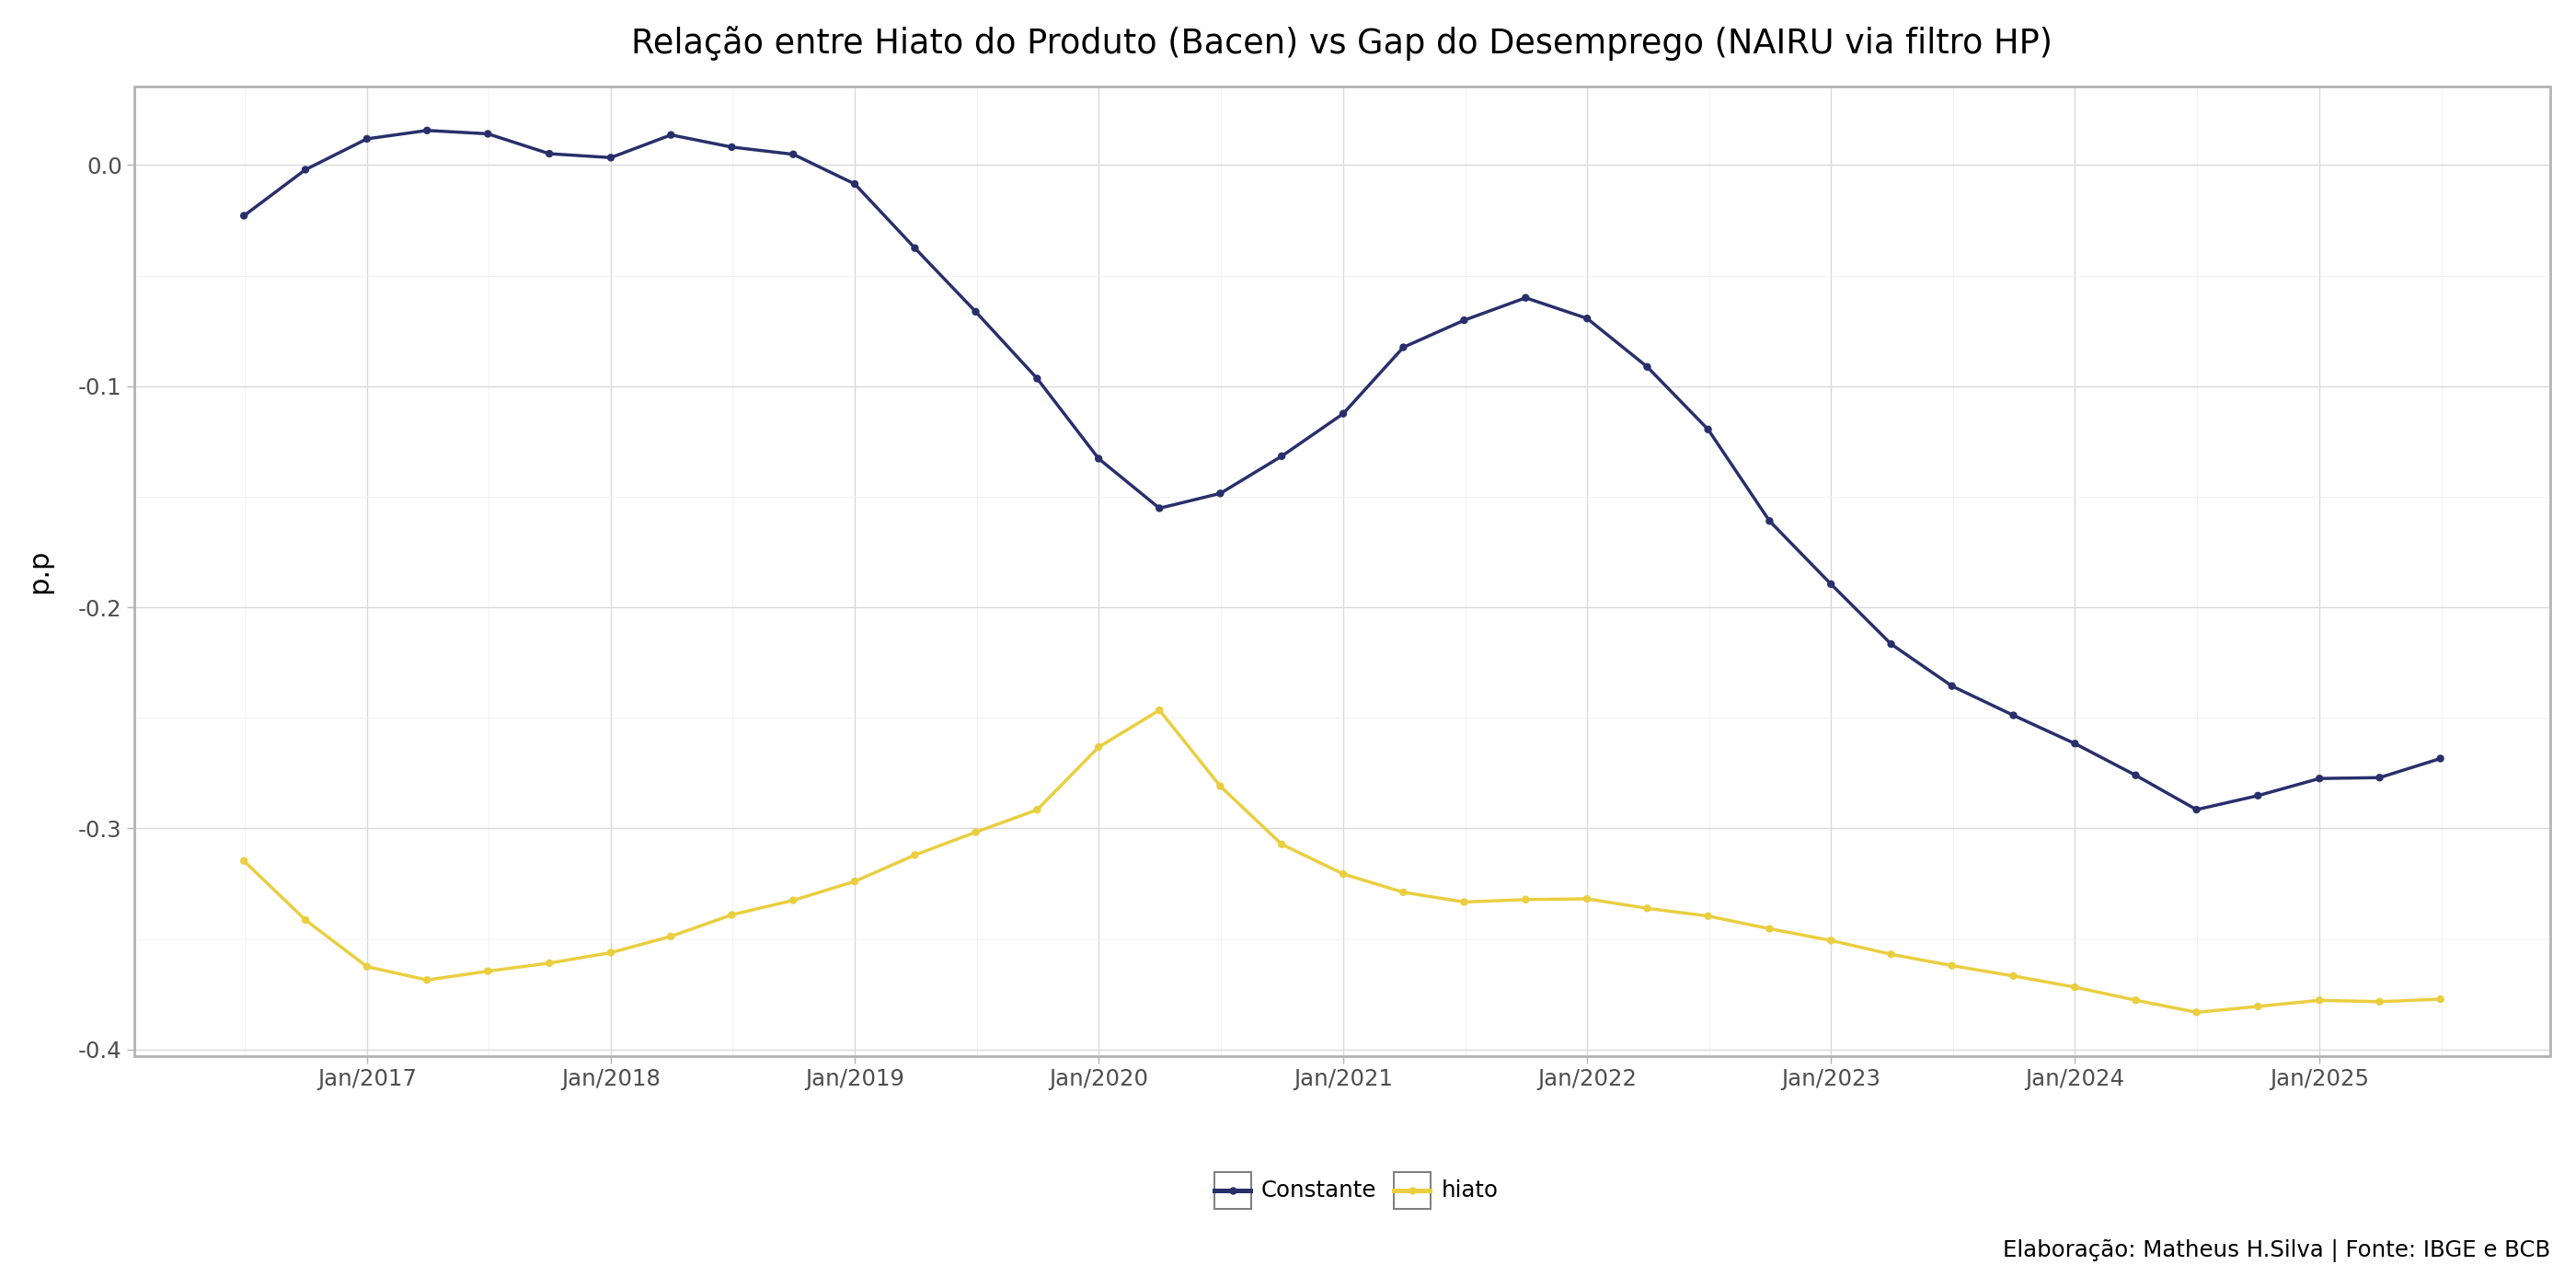

In [43]:
#Gráfico
colors = {'blue': '#282f6b',
          'yellow': '#eace3f',
          'red': '#b22200',
          'green': '#224f20',
          'purple': '#5f487c',
          'gray': '#666666',
          'orange': '#b35c1e'}
(ggplot(okun_roll_long, aes(x= 'Date', y= 'value', color= 'variable'))+
 geom_line(size = 0.7)+
 geom_point(size = 0.7)+
 scale_colour_manual(values=list(colors.values()))+
 scale_x_date(date_breaks='12 month', date_labels='%b/%Y')+
 labs(title= f'Relação entre Hiato do Produto (Bacen) vs Gap do Desemprego (NAIRU via filtro HP)',
      color='',
      x='',
      y='p.p',
      caption='Elaboração: Matheus H.Silva | Fonte: IBGE e BCB')+
 theme_light() + theme(figure_size= (14,7), legend_position='bottom')
 )